INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Quadro RTX 3000, compute capability 7.5


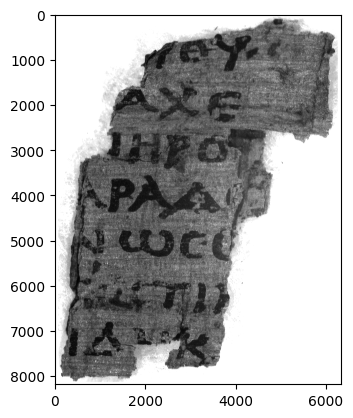

In [1]:
#Initial Setup and importing libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

import time
import glob
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

#Tensorflow memory growth
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

#data config
DATA_DIR = 'kaggle/input/vesuvius-challenge-ink-detection/'
BUFFER = 32
Z_DIM = 16
Z_START = 25

BATCH_SIZE = 16 #64 is giving OOM error

plt.imshow(Image.open(DATA_DIR + "train/1/ir.png"), cmap="gray")

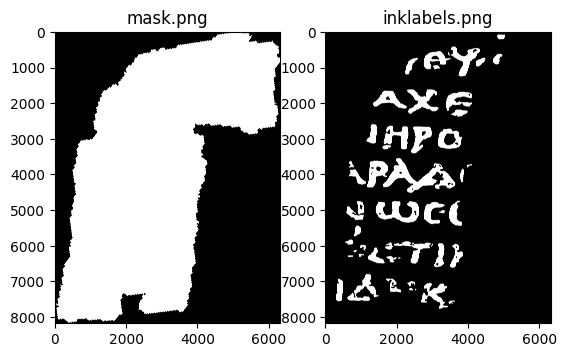

In [2]:
#Load Data
def load_mask(split, index):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/mask.png").convert('1')
    img_array = np.asarray(img)
    return tf.convert_to_tensor(img_array, dtype="bool")

def load_labels(split, index):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/inklabels.png")
    img_array = np.asarray(img)
    return tf.convert_to_tensor(img_array, dtype="bool")

mask = load_mask(split="train", index=1)
labels = load_labels(split="train", index=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()

In [3]:
def load_volume(split, index):
    z_slices_fname = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))[Z_START: Z_START + Z_DIM]
    z_slices = []
    for z, filename in tqdm(enumerate(z_slices_fname)):
        img = Image.open(filename)
        z_slice = np.array(img, dtype=np.int16)
        z_slices.append(z_slice)
    return tf.stack(z_slices, axis=-1)

volume = load_volume(split="train", index=1)

print(f"Volumne {volume.shape} - {volume.dtype}")

16it [00:04,  3.74it/s]


Volumne (8181, 6330, 16) - <dtype: 'int16'>


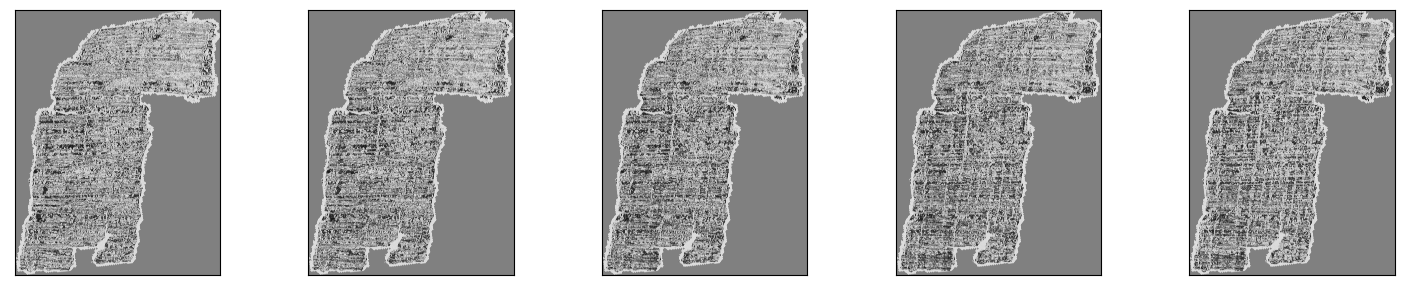

In [4]:
#Visualize some slices of the papyrus
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for z, ax in enumerate(axes):
    ax.imshow(volume[:,:, z], cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

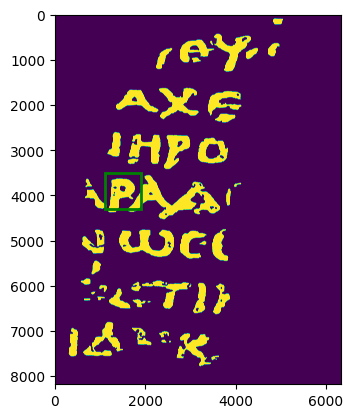

In [5]:
val_location = (3500, 1100)
val_zone_size = (800, 800)

fig, ax = plt.subplots()
ax.imshow(labels)
patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[0], val_zone_size[1],
                           linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(patch)
plt.show()

In [6]:
#Create a dataset that randomly samples coordinates
def sample_random_location(shape):
    random_train_x = tf.random.uniform(shape=(), minval=BUFFER, maxval=shape[0] - BUFFER - 1, dtype="int32")
    random_train_y = tf.random.uniform(shape=(), minval=BUFFER, maxval=shape[1] - BUFFER - 1, dtype="int32")
    random_train_location = tf.stack([random_train_x, random_train_y])
    return random_train_location

def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]]

sample_random_location_train = lambda x: sample_random_location(mask.shape)
is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

def is_in_val_zone(location, val_location, val_zone_size):
    x = location[0]
    y = location[1]
    x_match = val_location[0] - BUFFER <= x <= val_location[0] + val_zone_size[0] + BUFFER
    y_match = val_location[1] - BUFFER <= y <= val_location[1] + val_zone_size[1] + BUFFER
    return x_match and y_match

def is_proper_train_location(location):
    return not is_in_val_zone(location, val_location, val_zone_size) and is_in_mask_train(location)

train_locations_ds = tf.data.Dataset.from_tensor_slices([0]).repeat().map(sample_random_location_train, num_parallel_calls=tf.data.AUTOTUNE)
train_locations_ds = train_locations_ds.filter(is_proper_train_location)

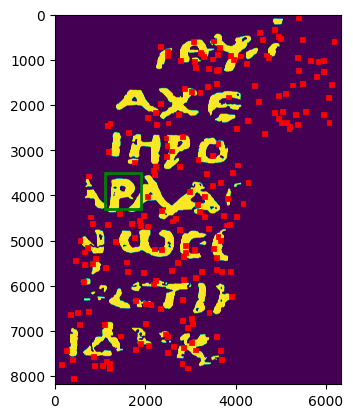

In [7]:
fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in train_locations_ds.take(200):
    patch = patches.Rectangle([y - BUFFER // 2, x - BUFFER // 2], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

val_patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[0], val_zone_size[1], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(val_patch)
plt.show()

In [8]:
def extract_subvolume(location, volume):
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :]
    subvolume = tf.cast(subvolume, dtype="float32") / 65535.
    return subvolume

def extract_labels(location, labels):
    x = location[0]
    y = location[1]
    label = labels[x, y]
    label = tf.cast(label, dtype="float32")
    return label

def extract_subvolume_and_label(location):
    subvolume = extract_subvolume(location, volume)
    label = extract_labels(location, labels)
    return subvolume, label

shuffle_buffer_size = BATCH_SIZE * 4

train_ds = train_locations_ds.map(extract_subvolume_and_label, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

In [9]:
for subvolume_batch, label_batch in train_ds.take(1):
    print(f"subvolume shape: {subvolume_batch.shape[1:]}")

subvolume shape: (64, 64, 16)


In [10]:
val_locations_stride = 3
val_locations = []
for x in range(val_location[0], val_location[0] + val_zone_size[0], val_locations_stride):
    for y in range(val_location[1], val_location[1] + val_zone_size[1], val_locations_stride):
        val_locations.append((x, y))

val_ds = tf.data.Dataset.from_tensor_slices(val_locations).map(extract_subvolume_and_label, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

In [11]:
t0 = time.time()
n = 200
for _ in train_ds.take(n):
    pass
print(f"Time per batch: {(time.time() - t0) / n:.4f}s")

Time per batch: 0.0075s


In [12]:
def trivial_baseline(dataset):
    total = 0
    matches = 0.
    for _, batch_label in tqdm(dataset):
        matches += tf.reduce_sum(tf.cast(batch_label, "float32"))
        total += tf.reduce_prod(tf.shape(batch_label))
    return 1. - matches / tf.cast(total, "float32")

score = trivial_baseline(val_ds).numpy()
print(f"Best validation score achievable trivially: {score * 100:.2f}% accuracy")

100%|██████████| 4456/4456 [00:24<00:00, 178.60it/s]

Best validation score achievable trivially: 55.87% accuracy


In [13]:
augmenter = keras.Sequential([
    layers.RandomFlip("horizontal"),
])

def augment_train_data(data, label):
    data = augmenter(data)
    return data, label

augmented_train_ds = train_ds.map(augment_train_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Test model to address OOM issues
def get_model(input_shape):
    inputs = keras.Input(input_shape)
    x = layers.Conv2D(kernel_size=3, filters=64, activation="relu")(inputs)

    for size in (64, 128, 256):
        residual = x
        x = layers.BatchNormalization()(x)
        x = layers.SeparableConv2D(kernel_size=3, filters=size, activation="relu", padding="same")(x)
        x = layers.SeparableConv2D(kernel_size=3, filters=size, activation="relu", padding="same")(x)
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(kernel_size=1,

In [14]:
def get_model(input_shape):
    inputs = keras.Input(input_shape)
    x = layers.Conv2D(kernel_size=3, filters=64, activation="relu")(inputs)

    for size in (64, 128, 256):
        residual = x
        x = layers.BatchNormalization()(x)
        x = layers.SeparableConv2D(kernel_size=3, filters=size, activation="relu", padding="same")(x)
        x = layers.SeparableConv2D(kernel_size=3, filters=size, activation="relu", padding="same")(x)
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(kernel_size=1, filters=size, strides=2, padding="same")(residual)
        x = layers.Add()([residual, x])

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    return model

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = get_model(input_shape=(BUFFER * 2, BUFFER * 2, Z_DIM))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

# Because train_ds is infinitely streaming, you need to specify steps_per_epoch
# i.e. the dataset has no epoch boundary on its own
model.fit(augmented_train_ds,
          validation_data=val_ds,
          epochs=5,
          steps_per_epoch=2000,
#           class_weight={0: 1., 1: 4.},  # We over-weight the rarer class (1)
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

In [15]:
model.save("model.keras")

In [16]:
del volume
del mask
del labels
del train_ds
del val_ds

# Manually trigger garbage collection
keras.backend.clear_session()
import gc
gc.collect()

model = keras.models.load_model("model.keras")

In [17]:
INFER_BATCH_SIZE = 128

def compute_predictions_map(split, index):
    print(f"Load data for {split}/{index}")

    test_volume = load_volume(split=split, index=index)
    test_mask = load_mask(split=split, index=index)

    test_locations = []
    stride = BUFFER // 2
    for x in range(BUFFER, test_volume.shape[0] - BUFFER, stride):
        for y in range(BUFFER, test_volume.shape[1] - BUFFER, stride):
            test_locations.append((x, y))

    print(f"{len(test_locations)} test locations (before filtering by mask)")

    sample_random_location_test = lambda x: sample_random_location(test_mask.shape)
    is_in_mask_test = lambda x: is_in_masked_zone(x, test_mask)
    extract_subvolume_test = lambda x: extract_subvolume(x, test_volume)

    test_locations_ds = tf.data.Dataset.from_tensor_slices(test_locations).filter(is_in_mask_test)
    test_ds = test_locations_ds.map(extract_subvolume_test, num_parallel_calls=tf.data.AUTOTUNE)

    predictions_map = np.zeros(test_volume.shape[:2], dtype="float16")

    print(f"Compute predictions")

    for loc_batch, patch_batch in tqdm(zip(test_locations_ds.batch(INFER_BATCH_SIZE), test_ds.batch(INFER_BATCH_SIZE))):
        predictions = model.predict_on_batch(patch_batch)
        for (x, y), pred in zip(loc_batch, predictions):
            predictions_map[x, y] = pred
            
    del test_volume
    del test_mask
    return predictions_map

In [18]:
predictions_map_1 = compute_predictions_map(split="train", index=1)

Load data for train/1


16it [00:04,  3.88it/s]


ResourceExhaustedError: {{function_node __wrapped__Pack_N_16_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[8181,6330,16] and type int16 on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Pack] name: stack

In [25]:
predictions_map_a = compute_predictions_map(split="test", index="a")
predictions_map_b = compute_predictions_map(split="test", index="b")

Load data for test/a


16it [00:01, 11.11it/s]


65464 test locations (before filtering by mask)
Compute predictions


327it [01:27,  3.74it/s]


Load data for test/b


16it [00:03,  4.30it/s]


ResourceExhaustedError: {{function_node __wrapped__Pack_N_16_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[5454,6330,16] and type int16 on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Pack] name: stack

In [26]:
def stats(predictions_map):
    size = predictions_map.shape[0] * predictions_map.shape[1]
    for thr in (0.1, 0.25, 0.5, 0.75):
        num_nonzero = np.count_nonzero(predictions_map_1 > thr)
        percent_nonzero = 100. * num_nonzero / size
        print(f"Percent above {thr}: {percent_nonzero:.2f}%")

In [27]:
stats(predictions_map_1)

NameError: name 'predictions_map_1' is not defined

In [28]:
stats(predictions_map_a)

NameError: name 'predictions_map_1' is not defined

In [29]:
stats(predictions_map_b)

NameError: name 'predictions_map_b' is not defined

In [30]:
def rle(predictions_map, threshold):
    flat_img = predictions_map.flatten()
    flat_img = np.where(flat_img > threshold, 1, 0).astype(np.uint8)

    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

In [31]:
threshold = 0.5

rle_a = rle(predictions_map_a, threshold=threshold)
rle_b = rle(predictions_map_b, threshold=threshold)
print("Id,Predicted\na," + rle_a + "\nb," + rle_b, file=open('submission.csv', 'w'))

NameError: name 'predictions_map_b' is not defined